## Causal Inference

In [5]:
#import required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report,roc_auc
from causalnex.inference import InferenceEngine

In [2]:
import sys
sys.path.insert(0,'../scripts/')
from plot_graph import plot_sm_graph
from Similarity_Index import jaccard_similarity_index
from Discretiser import discretise

Get data

In [6]:
data = pd.read_csv('../data/processed_data.csv')

In [4]:
data.head()

,driver_action,duration,distance,holiday,pilot_distance,Month,Day_of_week,fulfilled
0,0,3.0,20.984319,0,0.694264,7.0,3.0,1
1,1,3.0,20.984319,0,1.551694,7.0,3.0,0
2,1,3.0,20.984319,0,0.786777,7.0,3.0,0
3,1,3.0,20.984319,0,0.692054,7.0,3.0,0
4,1,3.0,20.984319,0,1.621848,7.0,3.0,0


Remove Month

In [7]:
data.drop(columns=['Month'],inplace=True)

Split data into train and test portions

In [8]:
train, test = train_test_split(data, train_size=0.75, test_size=0.25, random_state=10)

Get 20% of training data

In [7]:
sample_20 = train.sample(frac=0.2, random_state=42)

Create causal graph using from_pandas

In [8]:
sm = from_pandas(train)

Plot causal graph

/home/rex/.local/lib/python3.8/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


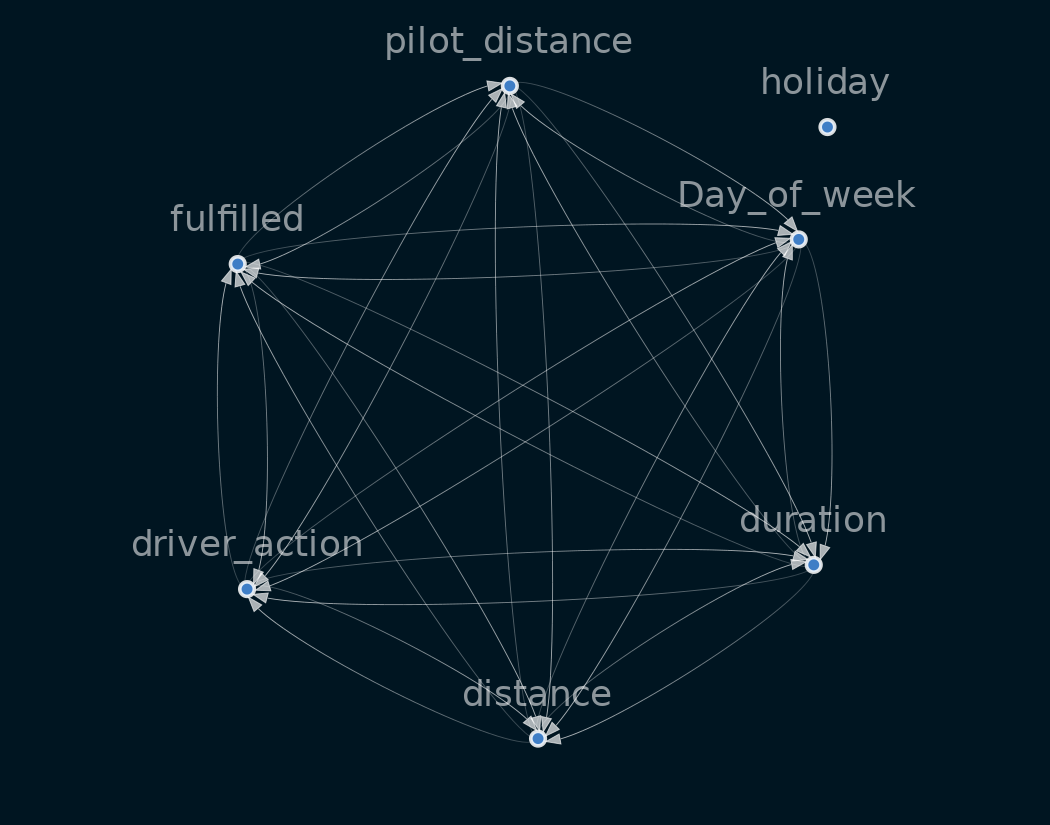

In [9]:
plot_sm_graph(sm)


Create causal graph using 20% of training data

In [10]:
sm20 = from_pandas(sample_20)

Plot causal graph

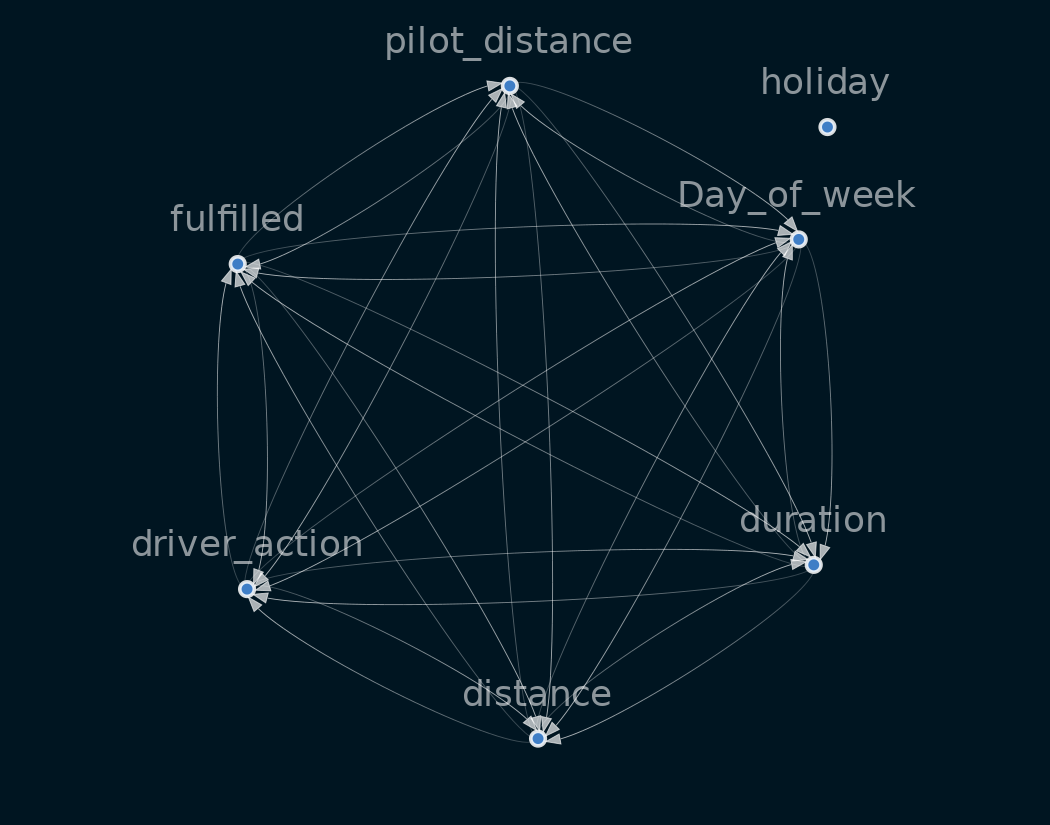

In [11]:
plot_sm_graph(sm20)


Calculate Jaccard similarity index for the baseline graph and sm20

In [12]:
similarity_index = jaccard_similarity_index(sm20,sm)
similarity_index

1.0

Remove edges below 0.5 threshold

/home/rex/.local/lib/python3.8/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


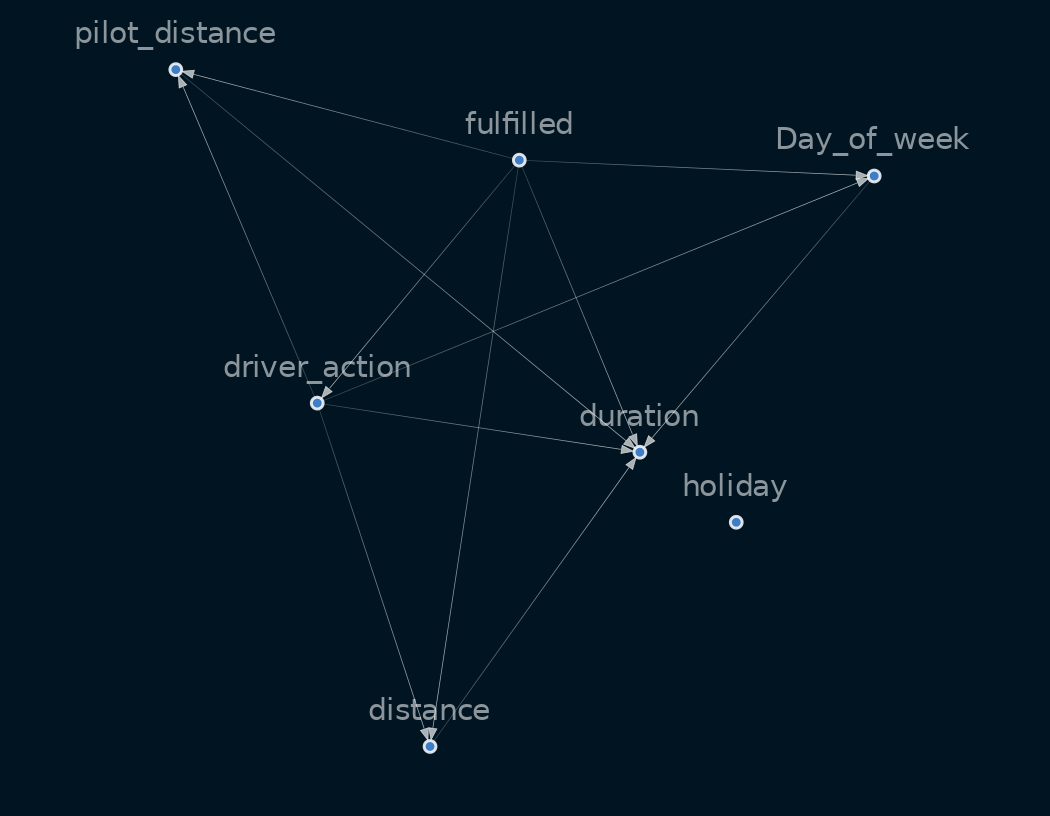

In [13]:
sm.remove_edges_below_threshold(0.5)
plot_sm_graph(sm)

Get largest subsection of the graph

/home/rex/.local/lib/python3.8/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: node 'driver_action', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


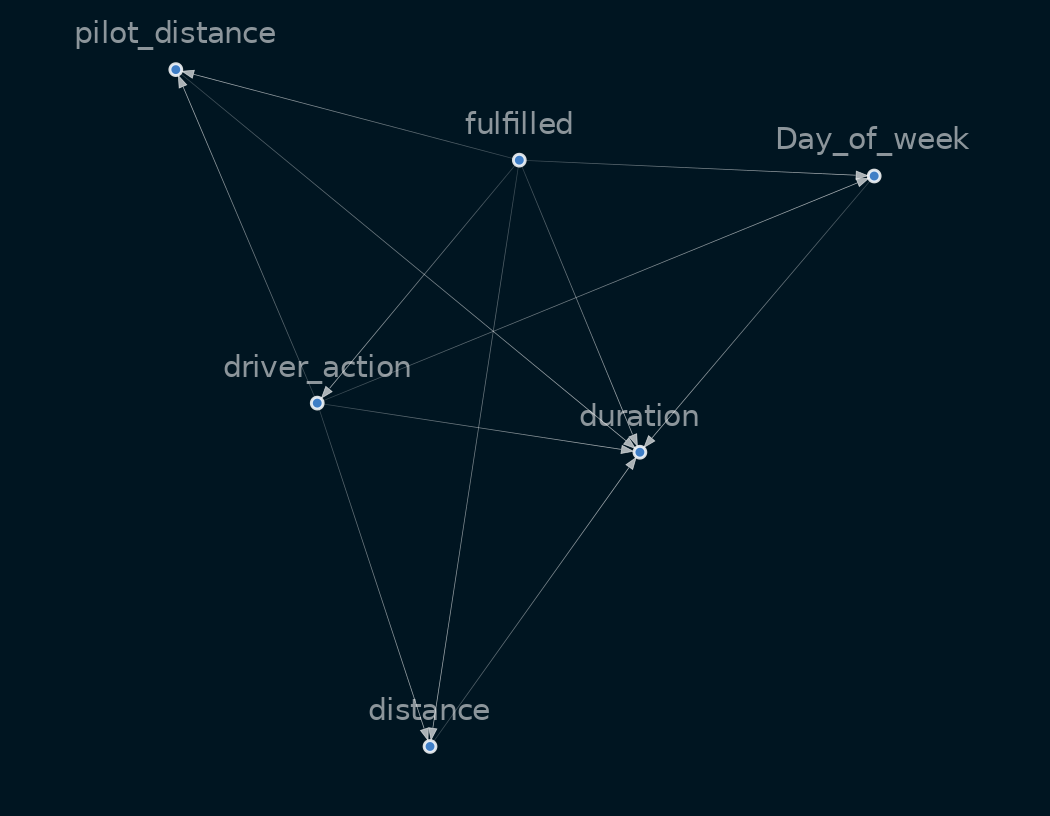

In [14]:
sm = sm.get_largest_subgraph()
plot_sm_graph(sm)

Discretise the training data

In [15]:
discretised_data = discretise(train)

/mnt/c/Users/User/Desktop/Causal-Inference/notebooks/../scripts/Discretiser.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = Discretiser(method="uniform", num_buckets=10, numeric_split_points=[1, 10]).transform(data[column].values)


Calculate conditional probability using BayesianNetwork

In [16]:
bn = BayesianNetwork(sm)

/home/rex/.local/lib/python3.8/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


Map fulfill column and driver action column to lables

In [17]:
fulfill_map = {0: "No", 1: "Yes"}
discretised_data["fulfilled"] = discretised_data["fulfilled"].map(fulfill_map)

/tmp/ipykernel_199/729570648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discretised_data["fulfilled"] = discretised_data["fulfilled"].map(fulfill_map)


In [18]:
driver_action_map = {0: "accept", 1: "reject"}
discretised_data["driver_action"] = train["driver_action"].map(driver_action_map)

/tmp/ipykernel_199/297933514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discretised_data["driver_action"] = train["driver_action"].map(driver_action_map)


In [19]:
discretised_data.head()

,driver_action,duration,distance,holiday,pilot_distance,Day_of_week,fulfilled
699854,reject,2,2,0,1,0,No
1228497,reject,2,1,0,1,1,No
590543,reject,2,1,0,1,0,No
540009,reject,2,1,0,1,1,No
352216,reject,2,1,0,1,1,No


Split the data into train and test sets

In [20]:
discretised_data_train, discretised_data_test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=10)

Fit discretised data into BayesianNetwork

In [21]:
bn = bn.fit_node_states(discretised_data)

Fit discretised training data into BayesianNetwork

In [22]:
bn = bn.fit_cpds(discretised_data_train, method="BayesianEstimator", bayes_prior="K2")

/home/rex/.local/lib/python3.8/site-packages/causalnex/network/network.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(self._node_states[col])
/home/rex/.local/lib/python3.8/site-packages/causalnex/network/network.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(self._node_states[col])
/home/rex/.local/lib/python3.8/site-packages/causalnex/network/network.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Get CPDs

In [23]:
bn.cpds["fulfilled"]

,
fulfilled,
No,0.983408
Yes,0.016592


Make predictions

In [24]:
predictions = bn.predict(discretised_data, "fulfilled")

Get classification report

In [25]:
classification_report(bn, discretised_data_test, "fulfilled")

/home/rex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fulfilled_No': {'precision': 0.9836902955973226,
  'recall': 1.0,
  'f1-score': 0.9917780994145731,
  'support': 114776},
 'fulfilled_Yes': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1903},
 'accuracy': 0.9836902955973226,
 'macro avg': {'precision': 0.4918451477986613,
  'recall': 0.5,
  'f1-score': 0.49588904970728653,
  'support': 116679},
 'weighted avg': {'precision': 0.9676465976523478,
  'recall': 0.9836902955973226,
  'f1-score': 0.9756024917800722,
  'support': 116679}}

Get ROC and AUC scores

In [26]:
roc, auc = roc_auc(bn, discretised_data_test, "fulfilled")
print(auc,roc)

0.9836902955973226 [(0.0, 0.0), (0.01630970440267743, 0.9836902955973226), (1.0, 1.0)]


Initialize inference engine

In [27]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["fulfilled"]

{'No': 0.983408420633628, 'Yes': 0.016591579366371755}

## Modeling

In [1]:
#import required packages
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import mlflow
import logging,os
import sqlite3

Setup logger and MLFlow

In [9]:
logging.basicConfig(filename='../log/log.log', filemode='a',encoding='utf-8', level=logging.DEBUG)
mlflow.set_experiment("Delivery optimization using Random Forest Regressor")

2022/10/23 17:58:28 INFO mlflow.tracking.fluent: Experiment with name 'Delivery optimization using Random Forest Regressor' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/User/Desktop/Causal-Inference/notebooks/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Delivery optimization using Random Forest Regressor', tags={}>

In [10]:
mlflow.log_param('Model', 'Random Forest Regressor')

Split featuer and target variables into training and testing sets

In [17]:
x_train = train.drop(columns=['fulfilled','driver_action'])
y_train = train['fulfilled']
x_test = test.drop(columns=['fulfilled','driver_action'])
y_test = test['fulfilled']

Set up ML pipeline with min-max scaler and random forest regressor

In [20]:
n_estimators = 35
max_depth=20
random_state=5
pipeline = Pipeline(steps = [('preprocessor', MinMaxScaler()),('model',RandomForestRegressor(n_estimators = n_estimators,max_depth=max_depth, random_state=random_state))])
mlflow.log_param('Number of estimators',n_estimators)
mlflow.log_param('Max depth',max_depth)
mlflow.log_param('Random state',random_state)

Fit training data into random forest model

In [21]:
random_forest_model = pipeline.fit(x_train, y_train)

Get performance score for the model

In [22]:
Score = random_forest_model.score(x_test, y_test)
y_pred= random_forest_model.predict(x_test)
report = str(data.columns)
mse = mean_squared_error(y_test, y_pred)
mlflow.log_metric('Score',Score)
mlflow.log_metric('Mean Squared Error',mse)
if not os.path.exists("Random Forest Regression reports"):
    os.makedirs("Random Forest Regression reports")
with open("Random Forest Regression reports/report.txt", "w") as f:
            f.write(report)
mlflow.log_artifacts("Random Forest Regression reports")


In [23]:
print("Score",Score,"\n","Mean Squared Error",mse)

Score 0.006127611217800255 
 Mean Squared Error 0.01644611985981944


Get feature importance

In [27]:
importance = random_forest_model.named_steps["model"].feature_importances_
fi_df = pd.DataFrame()
fi_df['feature'] = x_train.columns.to_list()
fi_df['feature_importances'] = importance
fi_df

,feature,feature_importances
0,duration,0.141286
1,distance,0.264620
2,holiday,0.000000
3,pilot_distance,0.555096
4,Day_of_week,0.038998


## SQL Database

Connect to SQL database

In [2]:
sqliteConnection = sqlite3.connect('feature_store.db')

Initialize cursor

In [3]:
cursor = sqliteConnection.cursor()

Create features table

In [6]:
cursor.execute("CREATE TABLE features(id n(5), feature char(30));")

Insert features list into features table

In [7]:
sqlite_insert_query = """INSERT INTO features
                          (id, feature) 
                           VALUES 
                          (1,'duration'),
                          (2,'distance'),
                          (3,'holiday'),
                          (4,'pilot_distance'),
                          (5,'Day_of_week')
                          """
count = cursor.execute(sqlite_insert_query)
sqliteConnection.commit()

Get all features in the table

In [9]:
cursor.execute("SELECT * FROM features;").fetchall()

[(1, 'duration'),
 (2, 'distance'),
 (3, 'holiday'),
 (4, 'pilot_distance'),
 (5, 'Day_of_week')]